In [2]:
import sys
import os
from scipy.optimize import curve_fit

# Get the project root (one level above notebooks/)
project_root = os.path.abspath("..")
sys.path.append(project_root)

print("Added to Python path:", project_root)


Added to Python path: c:\Users\YooNi\OneDrive\Desktop\Majorana-Neutrino-Hunt


In [3]:
import h5py
import numpy as np
import pandas as pd
# from src.parameters.tail_features import compute_LQ80

In [4]:
train_file = "../data/old/MJD_Train_0.hdf5"

with h5py.File(train_file, "r") as f:
    waveforms = np.array(f["raw_waveform"])
    ids = np.array(f["id"])

print("Loaded", len(waveforms), "waveforms")


Loaded 65000 waveforms


In [5]:
def print_hdf5_structure(name, obj):
    print(name)

with h5py.File(train_file, "r") as f:
    f.visititems(print_hdf5_structure)


detector
energy_label
id
psd_label_dcr
psd_label_high_avse
psd_label_low_avse
psd_label_lq
raw_waveform
run_number
tp0


In [6]:
def estimate_baseline(y, n_samples=200):
    """
    Returns baseline (mean, std) from the first n_samples.
    """
    y0 = np.asarray(y, dtype=float)[:n_samples]
    return float(np.mean(y0)), float(np.std(y0))


In [7]:
def exponential(t, a, tau1, b, tau2):
    """
    Double exponential decay model of the form:
        a * exp(-t/tau1) + b * exp(-t/tau2)

    This models the long falling edge of HPGe waveforms.
    """
    return a * np.exp(-t / tau1) + b * np.exp(-t / tau2)


In [8]:
# ------------------------------------------------------------
# Pole–Zero Correction 
# ------------------------------------------------------------
def pole_zero_correction(waveform, use_pz=False):
    """
    Applies pole–zero correction to the waveform tail.

    Parameters
    ----------
    waveform : np.ndarray
        Raw waveform.
    use_pz : bool
        If False, returns the waveform unchanged.
        If True, attempts exponential fitting and tail correction.

    Returns
    -------
    waveform_pz : np.ndarray
        Corrected waveform (or raw waveform if disabled/fitting failed).
    corrected_tail : np.ndarray
        The corrected tail region (or raw tail if not corrected).
    """

    # --------------------------------------------------------
    # If disabled → return original waveform immediately
    # --------------------------------------------------------
    y = np.asarray(waveform, dtype=float)
    if not use_pz:
        return y, y

    # --------------------------------------------------------
    # Identify 98 percent rise point (start of decay)
    # --------------------------------------------------------
    peak_value = np.max(y)
    t98_idx = np.where(y >= 0.98 * peak_value)[0]
    if len(t98_idx) == 0:
        return y, y
    t98 = int(t98_idx[0])

    # Tail region
    tail_values = y[t98:]
    tail_time = np.arange(len(tail_values))

    # --------------------------------------------------------
    # Fit a double exponential tail
    # Use tighter bounds to avoid overflow and unrealistic fits
    # --------------------------------------------------------
    try:
        params, _ = curve_fit(
            exponential,
            tail_time,
            tail_values,
            p0=[peak_value, 300.0, peak_value * 0.1, 1500.0],  # initial guesses
            bounds=(
                [0, 10, 0, 10],          # lower bounds
                [peak_value * 2, 5000, peak_value * 2, 5000]  # upper bounds
            ),
            maxfev=4000
        )

        # Decay model
        model_decay = exponential(tail_time, *params)

        # Reference point for normalization
        f_t0 = np.mean(tail_values[:5])
        f_pz = f_t0 / model_decay

        corrected_tail = tail_values * f_pz

        waveform_pz = y.copy()
        waveform_pz[t98:] = corrected_tail

        return waveform_pz, corrected_tail

    except Exception:
        # If fitting fails, return original
        return y, y



In [9]:
def compute_LQ80(waveform):
    """
    Late Charge 80:
    Area difference between raw and PZ-corrected waveform
    starting at the 80 percent rising edge.
    """
    # ---- IMPORTANT FIX ----
    waveform_pz, _ = pole_zero_correction(waveform, use_pz=True)

    y  = np.asarray(waveform, dtype=float)
    yc = np.asarray(waveform_pz, dtype=float)

    # Baseline
    baseline, _ = estimate_baseline(y)

    # Peak
    peak_val = float(np.max(y))
    target = baseline + 0.80 * (peak_val - baseline)

    # Rising-edge crossing
    idx = np.where(y >= target)[0]
    if len(idx) == 0:
        return np.nan

    i80 = int(idx[0])

    # Time index for integration
    t = np.arange(len(y), dtype=float)

    area_raw  = float(np.trapezoid(y[i80:],  t[i80:]))
    area_corr = float(np.trapezoid(yc[i80:], t[i80:]))

    return area_raw - area_corr


In [10]:
# compute lq80 for everything
LQ80_values = []

for i, wf in enumerate(waveforms):
    val = compute_LQ80(wf)
    LQ80_values.append(val)

LQ80_values = np.array(LQ80_values)

In [11]:
# output 
formatted_ids = [f"{id_}_train_0" for id_ in ids]

df = pd.DataFrame({
    "id": formatted_ids,
    "LQ80": LQ80_values
})


In [12]:
# save to csv
output_path = "LQ80_train_0.csv"
df.to_csv(output_path, index=False)

print("Saved to", output_path)
df.head()

Saved to LQ80_train_0.csv


,id,LQ80
0,0_train_0,-717094.898532
1,1_train_0,-331957.541919
2,2_train_0,-425532.152706
3,3_train_0,-306980.459766
4,4_train_0,-362746.925366


In [13]:
print(df["LQ80"].describe())
print("NaNs:", df["LQ80"].isna().sum())


count    6.500000e+04
mean    -7.730866e+05
std      7.918739e+05
min     -5.270591e+06
25%     -7.677999e+05
50%     -4.265823e+05
75%     -3.061083e+05
max      1.698377e+04
Name: LQ80, dtype: float64
NaNs: 0


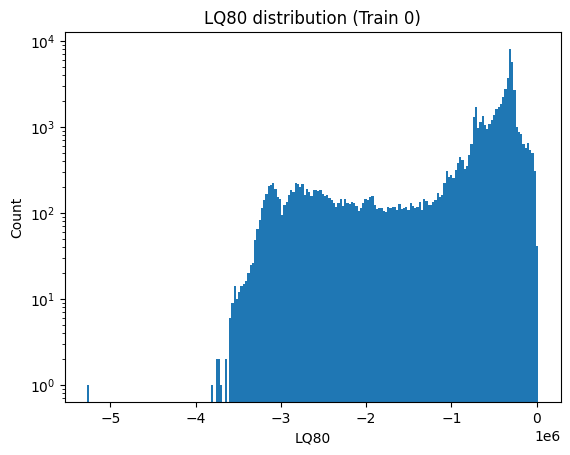

In [14]:
import matplotlib.pyplot as plt
import numpy as np

vals = df["LQ80"].to_numpy(dtype=float)
vals = vals[np.isfinite(vals)]

plt.figure()
plt.hist(vals, bins=200)
plt.yscale("log")
plt.xlabel("LQ80")
plt.ylabel("Count")
plt.title("LQ80 distribution (Train 0)")
plt.show()
